In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import lxml
import numpy as np
import networkx as nx

In [16]:
from sklearn.cluster import SpectralClustering

In [2]:
sp500 = list(pd.read_csv('sp500_companies.csv')['Symbol'])

In [3]:
for tick in ['ANSS', 'DFS', 'JNPR', 'WBA', 'HES', 'PARA']:
    sp500.remove(tick)

In [4]:
prices = yf.download(
    sp500,
    start="2025-01-01",
    end="2025-12-31"
)["Close"]

[*********************100%***********************]  496 of 496 completed


In [5]:
prices = prices.ffill()
returns = prices.pct_change().dropna()
returns.head()

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-03,0.016938,-0.002009,0.009920,0.032172,0.003438,0.000219,0.014420,-0.023651,0.019021,-0.003385,...,-0.000744,0.013219,-0.005728,-0.002543,0.005125,0.010608,-0.000898,0.000096,0.021107,0.004305
2025-01-06,0.005454,0.006739,-0.006180,-0.003758,-0.006940,-0.007221,-0.007122,0.001417,0.012212,-0.008392,...,-0.007863,0.004936,0.015483,-0.015149,-0.001113,-0.002902,-0.024505,-0.008710,0.008855,0.015859
2025-01-07,0.007183,-0.011388,-0.003165,-0.028920,0.003185,0.016641,0.014403,-0.019829,-0.009771,-0.004030,...,0.007795,-0.017193,-0.025529,0.007676,0.009375,-0.009072,-0.012445,-0.004152,0.001973,-0.014527
2025-01-08,-0.002984,0.002023,-0.005737,-0.003732,0.007496,0.004444,0.003760,-0.007217,0.021170,0.008295,...,0.016667,-0.011781,-0.015525,0.011426,-0.016736,0.001123,-0.006301,-0.015417,0.002247,0.009358
2025-01-10,0.003431,-0.024104,-0.018655,-0.008945,-0.016980,-0.026872,-0.022196,-0.032556,-0.036609,0.025080,...,-0.003915,-0.014090,-0.000246,-0.045489,-0.003647,-0.016306,-0.035150,0.029545,-0.028866,-0.010302


In [6]:
log_returns = np.log1p(returns)

In [9]:
corr_matrix = log_returns.corr()
dist = np.sqrt(2 * (1 - corr_matrix))
similarity = np.exp(-dist)

In [13]:
import matplotlib.pyplot as plt

In [15]:
G = nx.from_pandas_adjacency(similarity)

# Normalized Laplacian
L = nx.normalized_laplacian_matrix(G).toarray()

# Eigen-decomposition
eigvals, eigvecs = np.linalg.eigh(L)

# 2D spectral embedding (skip trivial eigenvector)
X_embed = eigvecs[:, 1:3]

In [24]:
sc = SpectralClustering(
    n_clusters=2,
    affinity="precomputed",
    random_state=0
)

labels = sc.fit_predict(similarity)


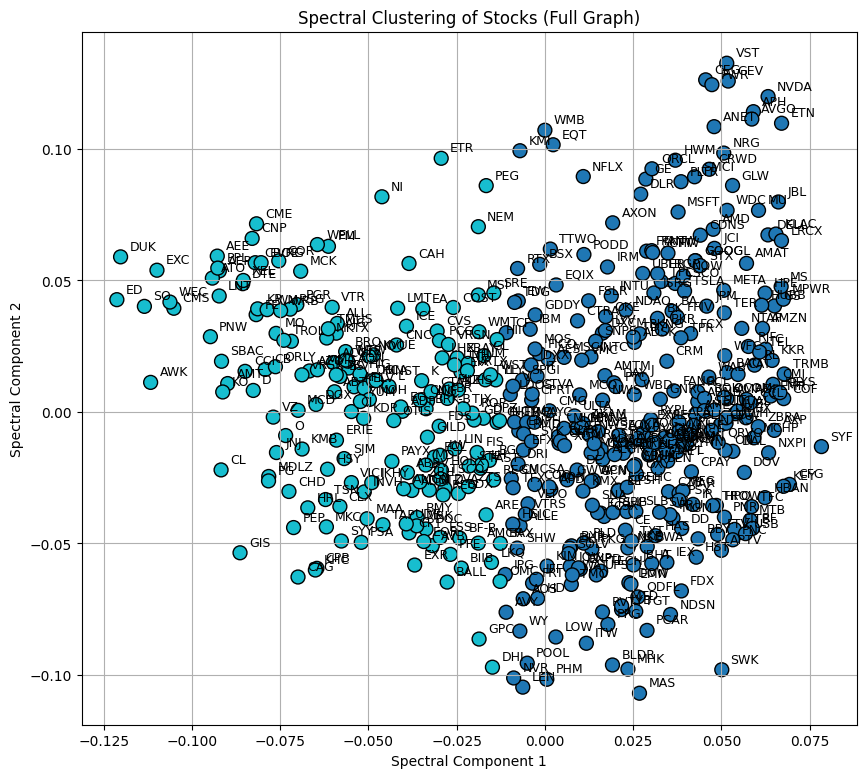

In [31]:
plt.figure(figsize=(10, 9))

scatter = plt.scatter(
    X_embed[:, 0],
    X_embed[:, 1],
    c=labels,
    cmap="tab10",
    s=100,
    edgecolors="k"
)

for i, ticker in enumerate(similarity.index):
    plt.text(
        X_embed[i, 0] + 0.0025,
        X_embed[i, 1] + 0.0025,
        ticker,
        fontsize=9
    )

plt.xlabel("Spectral Component 1")
plt.ylabel("Spectral Component 2")
plt.title("Spectral Clustering of Stocks (Full Graph)")
plt.grid(True)
plt.show()


In [34]:
import community.community_louvain as community_louvain

In [35]:
partition = community_louvain.best_partition(G, weight="weight")

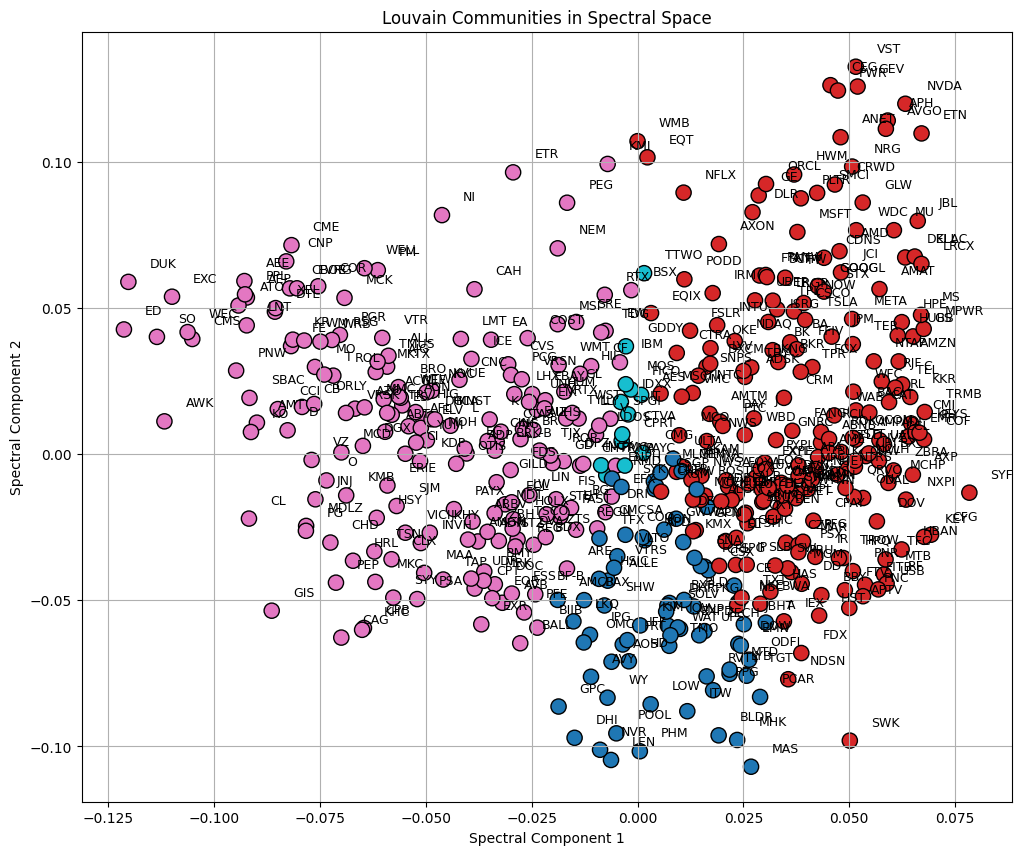

In [38]:
# Normalized Laplacian
L = nx.normalized_laplacian_matrix(G).toarray()
eigvals, eigvecs = np.linalg.eigh(L)

# 2D spectral embedding
X_embed = eigvecs[:, 1:3]

plt.figure(figsize=(12, 10))

plt.scatter(
    X_embed[:, 0],
    X_embed[:, 1],
    c=list(partition.values()),
    cmap="tab10",
    s=120,
    edgecolors="k"
)

for i, node in enumerate(G.nodes()):
    plt.text(
        X_embed[i, 0] + 0.005,
        X_embed[i, 1] + 0.005,
        node,
        fontsize=9
    )

plt.xlabel("Spectral Component 1")
plt.ylabel("Spectral Component 2")
plt.title("Louvain Communities in Spectral Space")
plt.grid(True)
plt.show()
